# Marine Heatwaves Definition

This document describes the `marineHeatWaves` module for python which implements the Marine Heatwave (MHW) definition of Hobday et al. (*manuscript submitted to Progress in Oceanography*). This software is demonstrated by applying the MHW definition to a stochastic red noise process. This was developed as an interactive ipython notebook which the user can run themselves provided they have the required python modules (`numpy`, `scipy`, `datetime`, and `matplotlib`).

In [1]:
# Load required modules
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load marineHeatWaves definition module
import marineHeatWaves as mhw

## Generate synthetic temperature time series

The following code will generate a synthetic daily temperature time series, over the time span 1 Jan 1982 to 31 Dec 2014, using an order-1 autoregressive process.

In [3]:
# Generate time vector using datetime format (January 1 of year 1 is day 1)
t = np.arange(date(1982,1,1).toordinal(),date(2014,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]
# Generate synthetic temperature time series
sst = np.zeros(len(t))
sst[0] = 0 # Initial condition
a = 0.85 # autoregressive parameter
for i in range(1,len(t)):
    sst[i] = a*sst[i-1] + 0.75*np.random.randn() + 0.5*np.cos(t[i]*2*np.pi/365.25)
sst = sst - sst.min() + 5.

## Marine Heatwave Detection

The marineHeatWaves (`mhw`) module consists of a number of functions for the detection and characterization of MHWs. The main function is the detection function (`detect`) which takes as input a time series of temperature (and a corresponding time vector) and outputs a set of detected MHWs. We first run the MHW detection algorithm which returns the variable `mhws`, consisting of the detected MHWs, and `clim`, consisting of the climatological (varying by day-of-year) seasonal cycle and extremes threshold:


In [4]:
mhws, clim = mhw.detect(t, sst)

This algorithm has detected the following number of MHW events:

In [5]:
mhws['n_events']

64

The first ten events, for example, have the following maximum intensities (in $^\circ$C):

In [6]:
mhws['intensity_max'][0:10]

[2.7470993422162007,
 2.7215288437009413,
 3.7466202883283426,
 3.3190123418252426,
 2.8881418365212017,
 2.915223091062714,
 3.0461857780071355,
 4.579431842989617,
 3.8544825571829335,
 2.4218747809793832]

Let's have a look at some properties of the event with the largest maximum intensity

In [7]:
ev = np.argmax(mhws['intensity_max']) # Find largest event
print('Maximum intensity:', mhws['intensity_max'][ev], 'deg. C')
print('Average intensity:', mhws['intensity_mean'][ev], 'deg. C')
print('Cumulative intensity:', mhws['intensity_cumulative'][ev], 'deg. C-days')
print('Duration:', mhws['duration'][ev], 'days')
print('Start date:', mhws['date_start'][ev].strftime("%d %B %Y"))
print('End date:', mhws['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 5.159649427786091 deg. C
Average intensity: 3.7930061711906915 deg. C
Cumulative intensity: 45.516074054288296 deg. C-days
Duration: 12 days
Start date: 26 December 2007
End date: 06 January 2008


and a closer look at the identified MHW event:

Text(0, 0.5, 'SST [$^\\circ$C]')

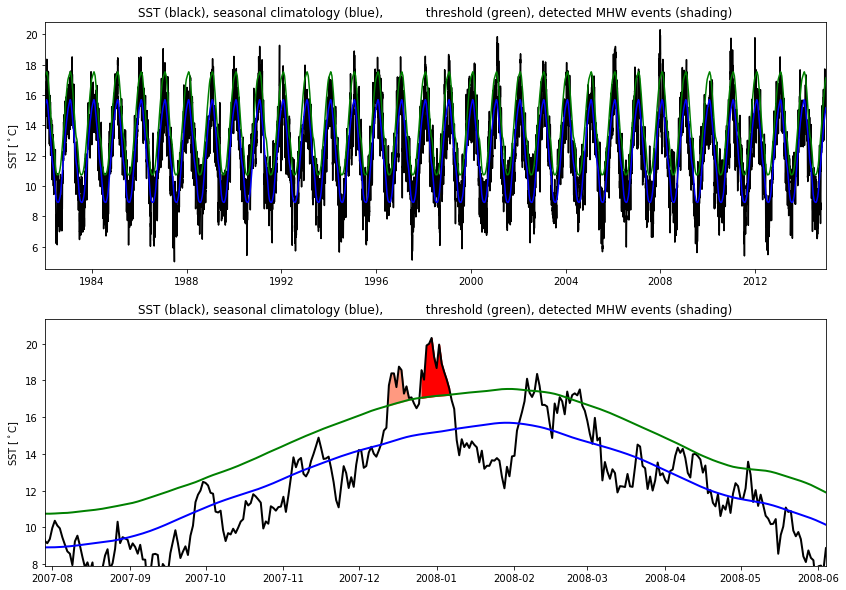

In [8]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, sst, 'k-')
plt.plot(dates, clim['thresh'], 'g-')
plt.plot(dates, clim['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.xlim(t[0], t[-1])
plt.ylim(sst.min()-0.5, sst.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest and shade accordingly
t1 = np.where(t==mhws['time_start'][ev])[0][0]
t2 = np.where(t==mhws['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], \
                 color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, sst, 'k-', linewidth=2)
plt.plot(dates, clim['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.xlim(mhws['time_start'][ev]-150, mhws['time_end'][ev]+150)
plt.ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
plt.ylabel(r'SST [$^\circ$C]')

Yep, It's certainly picked out the largest event in the series (dark red shading). This event also seems to have been preceded and succeeded by a number of shorter, weaker events (light red shading). Let's have a look at how the MHW statistics are distributed across all the detected events:

Text(0.5, 0, 'MHW event number')

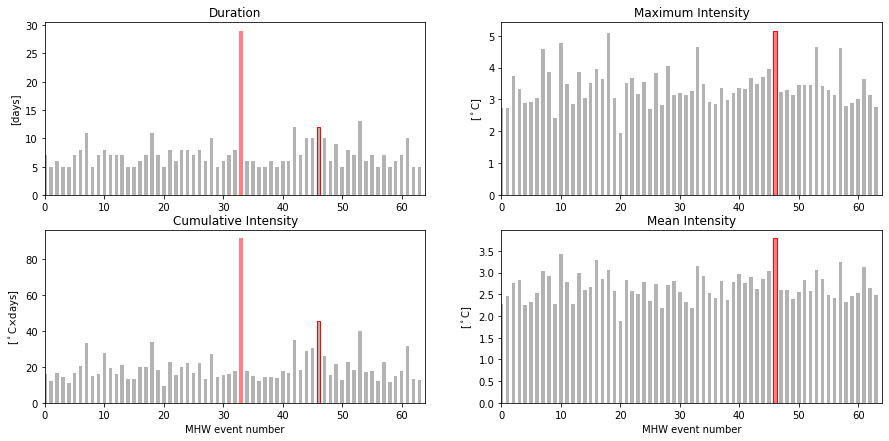

In [9]:
plt.figure(figsize=(15,7))
# Duration
plt.subplot(2,2,1)
evMax = np.argmax(mhws['duration'])
plt.bar(range(mhws['n_events']), mhws['duration'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['duration'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.ylabel('[days]')
plt.title('Duration')
# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws['intensity_max'])
plt.bar(range(mhws['n_events']), mhws['intensity_max'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_max'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_max'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')
# Mean intensity
plt.subplot(2,2,4)
evMax = np.argmax(mhws['intensity_mean'])
plt.bar(range(mhws['n_events']), mhws['intensity_mean'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_mean'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_mean'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel('MHW event number')
# Cumulative intensity
plt.subplot(2,2,3)
evMax = np.argmax(mhws['intensity_cumulative'])
plt.bar(range(mhws['n_events']), mhws['intensity_cumulative'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_cumulative'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_cumulative'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel('MHW event number')

The red shaded bars show the largest event on record by duration, maximum intensity, cumulative intensity, and mean intensity, while the red-outlined bars show the specific event chosen above (which happens to be largest by maximum intensity). We can see how this event ranks according to the other metrics as follows:

In [10]:
rank, returnPeriod = mhw.rank(t, mhws)
print("The 2012 NWA event is ranked number " \
        + str(rank['duration'][ev]) + " by duration")
print("The 2012 NWA event is ranked number " \
        + str(rank['intensity_max'][ev]) + " by maximum intensity")
print("The 2012 NWA event is ranked number " \
        + str(rank['intensity_mean'][ev]) + " by mean intensity")
print("The 2012 NWA event is ranked number " \
        + str(rank['intensity_cumulative'][ev]) + " by cumulative intensity")

The 2012 NWA event is ranked number 4 by duration
The 2012 NWA event is ranked number 1 by maximum intensity
The 2012 NWA event is ranked number 1 by mean intensity
The 2012 NWA event is ranked number 2 by cumulative intensity


We can even look at the return periods for events with those properties:

In [11]:
print("The return period for an event with this duration was " \
        + str(returnPeriod['duration'][ev]) + " years")
print("The return period for an event with this maximum intensity was " \
        + str(returnPeriod['intensity_max'][ev]) + " years")
print("The return period for an event with this mean intensity was " \
        + str(returnPeriod['intensity_mean'][ev]) + " years")
print("The return period for an event with this cumulative intensity was " \
        + str(returnPeriod['intensity_cumulative'][ev]) + " years")

The return period for an event with this duration was 8.499828884325805 years
The return period for an event with this maximum intensity was 33.99931553730322 years
The return period for an event with this mean intensity was 33.99931553730322 years
The return period for an event with this cumulative intensity was 16.99965776865161 years


## Block-averaged Marine Heatwave properties

The marineHeatWaves (`mhw`) module also consists of functions to calculate the average of MHW properties over blocks in time (e.g., annually, decadally). The block-averaging function (`blockAverage`) takes as input a set of detected MHWs (i.e., the output from `detect`, the detection function described above) and outputs the MHW properties averaged over the specified block-length. This output can then be passed through the `meanTrend` function in order to calculate the time-mean and linear trend of the MHW properties over the measurement period.

Let's start by applying the block-averaging function to the Mediterranean MHWs which are stored in the variable `mhws`, using the default block length of 1 year (i.e., annual averages):

In [12]:
mhwBlock = mhw.blockAverage(t, mhws)

The variable `mhwBlock` has a set of keys which are time series of the MHW properties over the blocks. The central year of the blocks are stored in the key `years_centre` so we can look at, as an example, time series of MHW counts in each year and the average maximum intensity in each year:


Text(0.5, 1.0, 'Average MHW maximum intensity by year')

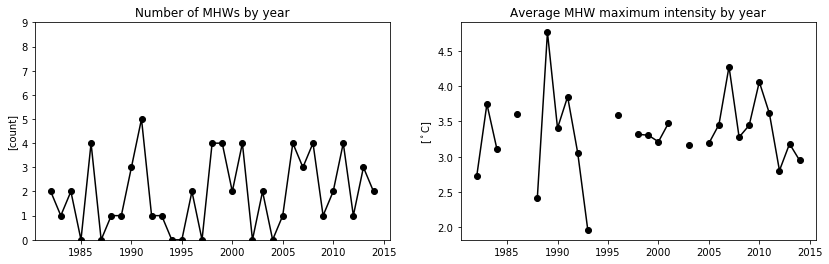

In [13]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(mhwBlock['years_centre'], mhwBlock['count'], 'k-o')
plt.ylim(0,9)
plt.ylabel('[count]')
plt.title('Number of MHWs by year')
plt.subplot(1,2,2)
plt.plot(mhwBlock['years_centre'], mhwBlock['intensity_max'], 'k-o')
plt.ylabel(r'[$^\circ$C]')
plt.title('Average MHW maximum intensity by year')

We can calculate the mean and trend of the MHW properties using the `meanTrend` function:

In [14]:
mean, trend, dtrend = mhw.meanTrend(mhwBlock)
print("There are on average " + str(mean['count']) + " MHWs in each year, \n \
with a linear trend of " + str(10*trend['count']) + " MHW events per decade \n \
This trend is statistically significant (p<0.05): " \
+ str(np.abs(trend['count']) > dtrend['count']) + "\n")

print("The average maximum intensity is " + str(mean['intensity_max']) + " deg. C, \n \
with a linear trend of " + str(10*trend['intensity_max']) + " deg. C per decade \n \
This trend is statistically significant (p<0.05): " \
+ str(np.abs(trend['intensity_max']) > dtrend['intensity_max']))

There are on average 1.9393939393939383 MHWs in each year, 
 with a linear trend of 0.32754010695187186 MHW events per decade 
 This trend is statistically significant (p<0.05): False

The average maximum intensity is 3.3423768824725886 deg. C, 
 with a linear trend of 0.03165594211469022 deg. C per decade 
 This trend is statistically significant (p<0.05): False
